This notebook builds a simple SSN model and demonstrates the speedup in simulation acheiveable by the GPU vs. CPU

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

import os

os.environ["CUDA_VISIBLE_DEVICES"]="2"

First we define all the SSN parameters

In [2]:
k = .001#overall recurrent strength
tau = .01#membrane time constant
dt = .0001#time step size
n = 2.2#nonlinearity power
T = .1#total time (in seconds)
nt = int(T/dt)#number of time steps
MAX_RATE = 1000#Maximum voltage (gets clipped above this)

J = np.array([[.01,-.1],[.1,-.01]])#recurrent strengths [[ee,ei],[ie,ii]]
S = np.array([[.5,.1],[2.,.1]])#recurrent lengths indices same as above

This defines the weight matrix and network size

(2000, 2000)


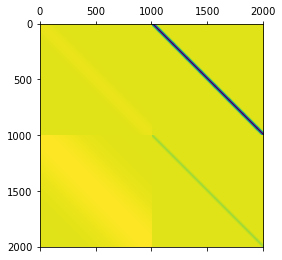

In [3]:
def expand(x,n):
    '''
    This is just a helper function to append singleton dimentions to tensors    
    '''
    if n == 0:
        return x
    else:
        return expand(np.expand_dims(x,-1),n-1)
    

size = 8 #physical size of network (in the same units as S)
N = 1000 #number of sites in the network (total number of neurons is twice this for e/i)
pos = np.expand_dims(np.linspace(0,size,N),0) #calculate the position of each site
dis = np.expand_dims(np.expand_dims(pos - pos.transpose(),0),0) #calculate the pairwise distance between sites

W = expand(J,2)*np.exp(- (dis**2)/(2*expand(S,2)**2))/np.sqrt(2*np.pi*expand(S,2)**2) #this computes W using the distances, S, and J

W = np.concatenate(W,axis = -2) #these lines are just rearranging W to be a matrix (before it had the e and i axes separated)
W = np.concatenate(W,axis = -1)

Wvar = np.float32(W)
#Wvar = tf.Variable(W)

print(W.shape)
plt.matshow(W)
plt.show()

This cell defines the computation.

the inputs are assumed constant. The initial state is set to zero (using a bit of a hack to get the right size of initial state)

`ssnnon` is the ssn nonlinearity and `get_next_SSN` is a function that takes the rates and inputs and computes the next time step rates.

I use the `tf.scan` function to perform the iterated application of the update function. Useage of `scan` is a bit complex, we can talk through it, or you can read the documentation.

Lastly, I generate inputs, just so that we can use the same value for both the GPU and CPU.

In [4]:
inputs = tf.placeholder(tf.float32,(None,2*N))
init_state = 0*inputs

def ssnnon(V):
    return tf.pow(tf.clip_by_value(V,clip_value_min = 0,clip_value_max = MAX_RATE),n)

def get_next_SSN(rate,ssn_in):
    return rate + dt*(- rate + k*ssnnon(tf.tensordot(rate,Wvar,axes = [[1],[1]]) + ssn_in))/tau

response = tf.transpose(tf.scan(lambda r,i:get_next_SSN(r,inputs),elems = tf.range(nt),initializer = init_state),[1,0,2])

print(response.shape)

inp = [np.float32(np.ones(2*N))*c for c in np.linspace(0,100,10)]

(?, 1000, 2000)


This cell creates a session (on the GPU) and runs it.

GPU time: 0.9304397106170654 seconds.


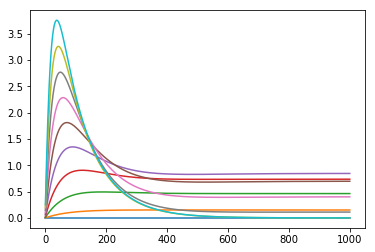

In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
t1 = time.time()
R = sess.run(response[:,:,0],{inputs:inp})
t2 = time.time()

print("GPU time: {} seconds.".format(t2 - t1))
sess.close()

plt.plot(R.transpose())
plt.show()

This cell creates a sesion using only the CPU and runs it. 

CPU time: 7.5037522315979 seconds.


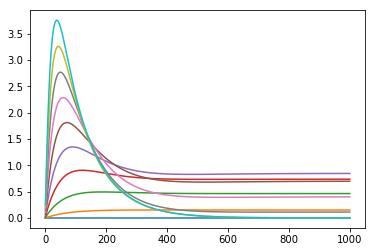

In [6]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
sess = tf.Session(config=config)
sess.run(init)
t1 = time.time()
R = sess.run(response[:,:,0],{inputs:inp})
t2 = time.time()

print("CPU time: {} seconds.".format(t2 - t1))
sess.close()

plt.plot(R.transpose())
plt.show()

The GPU was WAAAAY faster. Here are some things for you to try on your own:

    - change the number of time steps, size of network, etc. and see how the computation times changes with each of these.
    - modify the code so that the input is time-varying.
    - modify the code so that the number of time steps can be chosen at runtime.
    - change all the SSN parameters into tf variables and update them at runtime.